# Notebook for generating state

<!-- ## TO DO
<!-- - find source for rotation operation of CV state (just using copilot solution) -->
<!-- - find way to sample marginal distribution  -->
<!-- - recontruct state using samples -->


In [63]:
from numpy.typing import NDArray

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.integrate import simpson
from tqdm.notebook import tqdm, trange
import time

import seaborn as sns
rcparams = {
    "font.size": 20,        # suptitle size (upper most)
    "axes.titlesize": 18,   # fig title size (below suptitle)
    "axes.labelsize": 15,   # x,y label size
    "xtick.labelsize": 12,  # x tick label size
    "ytick.labelsize": 12,  # y tick label size
    "legend.fontsize": 15,  # legend font size
    "figure.figsize": (10, 6),  # figure size
}
sns.set_theme(context="notebook", style="darkgrid", rc=rcparams, font_scale=2, palette="colorblind")


## Background

**Goal:** Generate CV states and Corresponding Wigner function for use in marginal probability distribution $P(X_\theta)$ in phase-space. Sample the marginals for a range of angles and save the data $(X_\theta, \theta)$ for reconstruction

By simulating the data, we can check for the exact solution after of the state reconstruction.

Workflow:
- Using `qutip` we can easily generate an arbitrary continous-variable (CV) state for use as the groundtruth
- Create Wigner function for groundtruth
- Compute marginal distribution of Wigner function, $P(X_\theta)$, for a range of $\theta$
- Use the marginal probability distribution for reconstruction of state
- Measure in $X_\theta = \frac{1}{\sqrt{2}}\left(\hat{a}e^{-i\theta} + \hat{a}^\dagger e^{i\theta}\right)$ in [recontruction notebook](reconstruct.ipynb)


In [48]:

def generate_cv_state(state_type : str ="vacuum", N : int=30, **kwargs):
    """Generate a continuous variable quantum state.

    This function can create different types of continuous variable states,
    including vacuum, coherent, and squeezed states (more to be included)
    
    Parameters
    ---
    state_type : str
        The type of state to generate. Options are "vacuum", "coherent", and "squeezed".
    N : int
        The dimension of the Hilbert space.
    **kwargs : dict
        Additional parameters for specific state types.
    """
    if state_type == "vacuum":
        return qt.basis(N, 0)
    
    elif state_type == "coherent":
        kwargs.setdefault("alpha", 0.0 + 0j)  # Default value for alpha in case it is not applied
        kwargs.pop("parity", None)  # Remove parity from kwargs to avoid passing it to qt.coherent
        return qt.coherent(N, **kwargs)
    
    elif state_type == "squeezed":
        r = kwargs.get("r", 0.5)
        return qt.squeeze(N, r, **kwargs)
    elif state_type == "cat":
        # Generate a cat state using coherent states
        alpha = kwargs.get("alpha", 2.0)
        parity = kwargs.get("parity", "even")
        return cat_state(N, alpha=alpha, parity=parity)

    else:
        raise ValueError(f"Unknown state type: {state_type}")


def cat_state(N, alpha=2.0, parity="even"):
    coh_p = generate_cv_state("coherent", N, alpha=alpha)
    coh_m = generate_cv_state("coherent", N, alpha=-alpha)

    if parity == "even":
        return (coh_p + coh_m).unit()
    elif parity == "odd":
        return (coh_p - coh_m).unit()
    else:
        raise ValueError(f"Unknown parity: {parity}")

    
def rotate_state(rho, theta):
    rho = rho if rho.isoper else qt.ket2dm(rho)
    N = rho.shape[0]
    a = qt.destroy(N)
    U = (-1j*theta * a.dag() * a).expm()
    return U * rho * U.dag()

test = generate_cv_state("coherent", 3, alpha=2 - 2j)


In [49]:
def wigner_grid(rho : qt.Qobj | NDArray[np.float64], xmax : float | int=5., pmax : float | int=5., n : int=201, method : str ="clenshaw"):
    """Generate a Wigner grid for a given quantum state.

    rho : qt.Qobj | NDArray[np.float64]
        The density matrix or state vector of the quantum system.
        This can be a QuTiP object or a NumPy array.
    xmax : float | int
        The maximum value of the position variable.
    pmax : float | int
        The maximum value of the momentum variable.
    n : int
        The number of points in the grid.
        This determines the resolution of the Wigner function.
    method : str
        The method used for computing the Wigner function.
        This can be "clenshaw", "laguerre", "iterative", or "fft". See `qt.wigner()` for details.

    :doctest:
    >>> x, p, W = wigner_grid(rho, xmax=5, pmax=5, n=201, method="clenshaw")
    >>> W.shape
    (201, 201)

    """
    x = np.linspace(-xmax, xmax, n)
    p = np.linspace(-pmax, pmax, n)
    Xgrid, Pgrid = np.meshgrid(x, p)
    
    W = qt.wigner(rho, x, p, 
                  method=method,
                  )

    return x, p, W
X, P, W = wigner_grid(test)
X.shape, P.shape, W.shape

((201,), (201,), (201, 201))

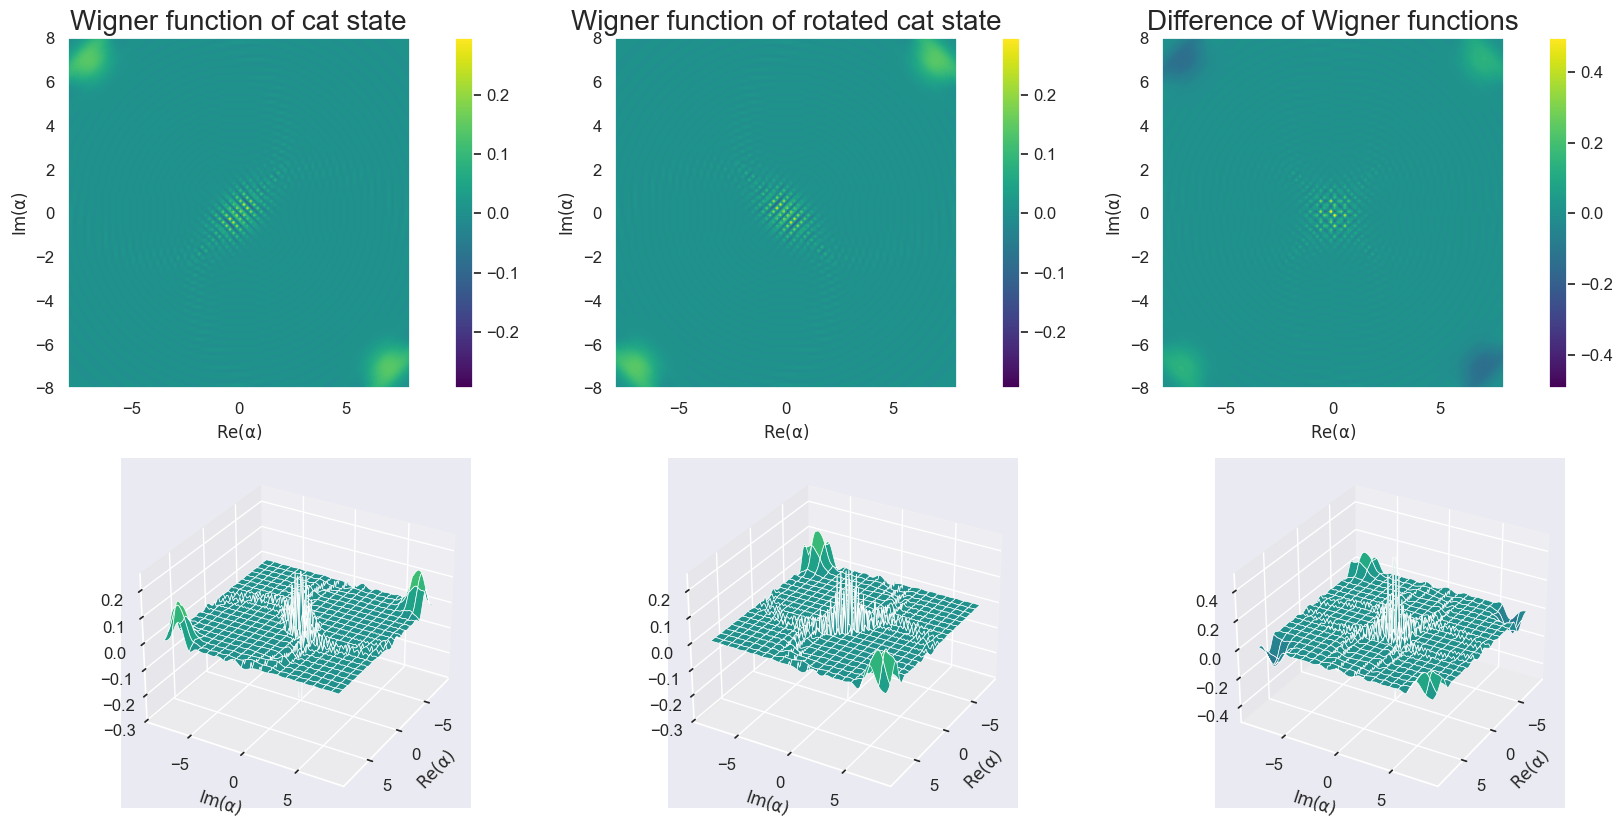

In [50]:
# plotting to ensure correct wigner function (takes ~40s to plot)
N = 100
alpha = -6 + 6.j # displacement
state_type = "cat" # state
parity = "odd" # parity for cat state |alpha> +- |-alpha>
state = generate_cv_state(state_type, 60, alpha=alpha, parity=parity) 
state_rotate = rotate_state(state, np.pi/2)
x = np.linspace(-8, 8, N)
p = np.linspace(-8, 8, N)

fig = plt.figure(figsize=(20,10))

axes = []
# first row of (2D) subplots
ax = fig.add_subplot(2, 3, 1)
axes.append(ax)
qt.plot_wigner(state, x, p, 
               cmap="viridis", fig=fig, ax=ax, colorbar=True, projection="2d", method="laguerre")

ax = fig.add_subplot(2, 3, 2)
axes.append(ax)
qt.plot_wigner(state_rotate, x, p, 
               cmap="viridis", fig=fig, ax=ax, colorbar=True, projection="2d", method="laguerre")

ax = fig.add_subplot(2, 3, 3)
axes.append(ax)
qt.plot_wigner(state_rotate - state.proj(), x, p, 
               cmap="viridis", fig=fig, ax=ax, colorbar=True, projection="2d", method="laguerre")

# second row of (3D) subplots
ax = fig.add_subplot(2, 3, 4, projection="3d")
axes.append(ax)
qt.plot_wigner(state, x, p, 
               cmap="viridis", fig=fig, ax=ax, colorbar=False, projection="3d", method="laguerre")

ax = fig.add_subplot(2, 3, 5, projection="3d")
axes.append(ax)
qt.plot_wigner(state_rotate, x, p,
               cmap="viridis", fig=fig, ax=ax, colorbar=False, projection="3d", method="laguerre")

ax = fig.add_subplot(2, 3, 6, projection="3d")
axes.append(ax)
qt.plot_wigner(state_rotate - state.proj(), x, p,
               cmap="viridis", fig=fig, ax=ax, colorbar=False, projection="3d", method="laguerre")


axes[0].set_title("Wigner function of cat state", fontsize=20)
axes[1].set_title("Wigner function of rotated cat state", fontsize=20)
axes[2].set_title("Difference of Wigner functions", fontsize=20)


for a in axes[3:]:
    a.view_init(elev=30, azim=30)

   
# fig.tight_layout()

## Computing marginal distributions


Compute marginals by rotating state and measure along $X$

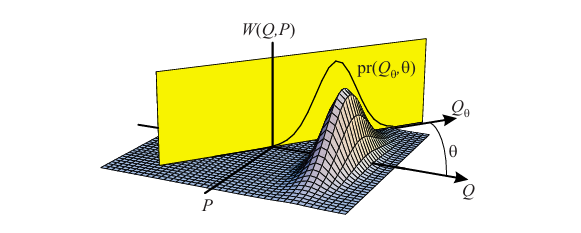

In [51]:
def marginal_from_wigner(W, p, axis="x"):
    """
    Compute a marginal by integrating the Wigner function along one axis.  
    axis='p' gives ∫ W(x,p) dp -> P(x); axis='x' gives ∫ W(x,p) dx -> P(p).
    """
    if axis == "x":
        dx = p[1] - p[0]  # reuse grid spacing argument if needed
        P, dist = simpson(W, axis=1, dx=dx), dx  # integrate over x (position -- columns) return number of rows
    elif axis == "p":
        dp = p[1] - p[0]
        P, dist = simpson(W, axis=0, dx=dp), dp  # integrate over p (momentum -- rows) return number of columns
    else:
        raise ValueError("axis must be 'p' or 'x'")
    return P, dist


def marginal_angles(state, thetas, axis="p"):
    marginals = {}
    measurements = []
    thetalist = []
    for i in tqdm(range(len(thetas)), desc="Computing marginals"):
        rot = rotate_state(state, thetas[i])
        x, p, W = wigner_grid(rot, n=300, xmax=8, pmax=8)
        marginals[i], _ = marginal_from_wigner(W, p, axis=axis)
        thetalist.append([thetas[i]]*len(marginals[i]))
        measurements.append(marginals[i])
    
    if axis == "x": # variable of integration: p -- variable left in marginal: x
        marginals["P"] = p
    elif axis == "p": # variable of integration: x -- variable left in marginal: p
        marginals["X"] = x
    thetalist = np.array(thetalist)
    measurements = np.array(measurements)
    return marginals, np.array((thetalist.ravel(), measurements.ravel()))


# Create Data

In [52]:
state_type = "coherent"
alpha = 2.0 + 1j
parity = "even"
N_cutoff = 30  # dimension of the Hilbert space
state = generate_cv_state(state_type, N_cutoff, alpha=alpha, parity=parity)  # generate a state

n_theta = 12
thetas = [np.pi/n_theta * i for i in range(n_theta)]
marginals, measurements = marginal_angles(state, thetas, axis="p")

Computing marginals:   0%|          | 0/12 [00:00<?, ?it/s]

In [53]:
#check that the cumsum is 1
for i in range(6):
    print(marginals[i].sum() * (marginals["X"][1] - marginals["X"][0]))
    # print(marginals[i].max())

0.9999999999999041
0.9999999999984064
0.9999999999972541
0.9999999999993893
0.9999999999999906
0.9999999999999974


## Plot data state

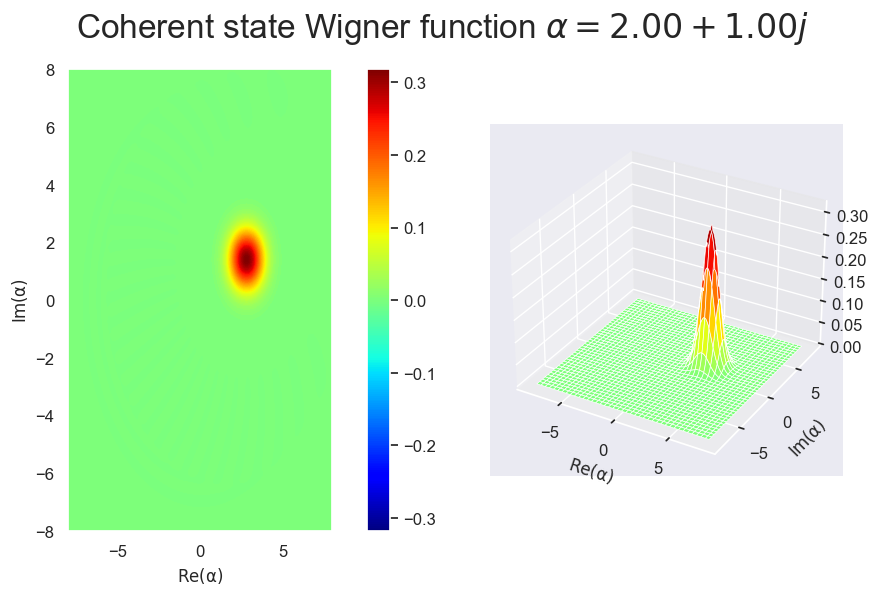

In [54]:
fig = plt.figure(figsize=(10, 6))
cmap = "jet"
ax1 = fig.add_subplot(1, 2, 1, aspect='auto')
ax2 = fig.add_subplot(1, 2, 2, projection="3d", aspect='auto')
qt.plot_wigner(state, ax=ax1, cmap=cmap, xvec=np.linspace(-8, 8, 200), yvec=np.linspace(-8, 8, 200), projection="2d", method="laguerre", colorbar=True)
qt.plot_wigner(state, ax=ax2, cmap=cmap, xvec=np.linspace(-8, 8, 200), yvec=np.linspace(-8, 8, 200), projection="3d", method="laguerre");

title = f"{state_type.capitalize()} state Wigner function $\\alpha = {alpha:.2f}$"
if state_type == "cat":
    title += f",\nparity = {parity}"

fig.suptitle(title)
fig_dir = "plots"
figname = f"{fig_dir}/generated_{state_type}_state_WF"
if state_type in ["cat", "coherent"]:
    figname += f"_alpha_{alpha.real:.2f}_{alpha.imag:.2f}"
    if state_type == "cat":
        figname += f"_parity_{parity}"
figname += ".png"
fig.savefig(figname)



## Save state

In [55]:
qt.fileio.qsave(state, filename="generated_state")
print("saved file to 'generated_state.qu'")

saved file to 'generated_state.qu'


## Plot marginals

Plotting marginals:   0%|          | 0/12 [00:00<?, ?it/s]

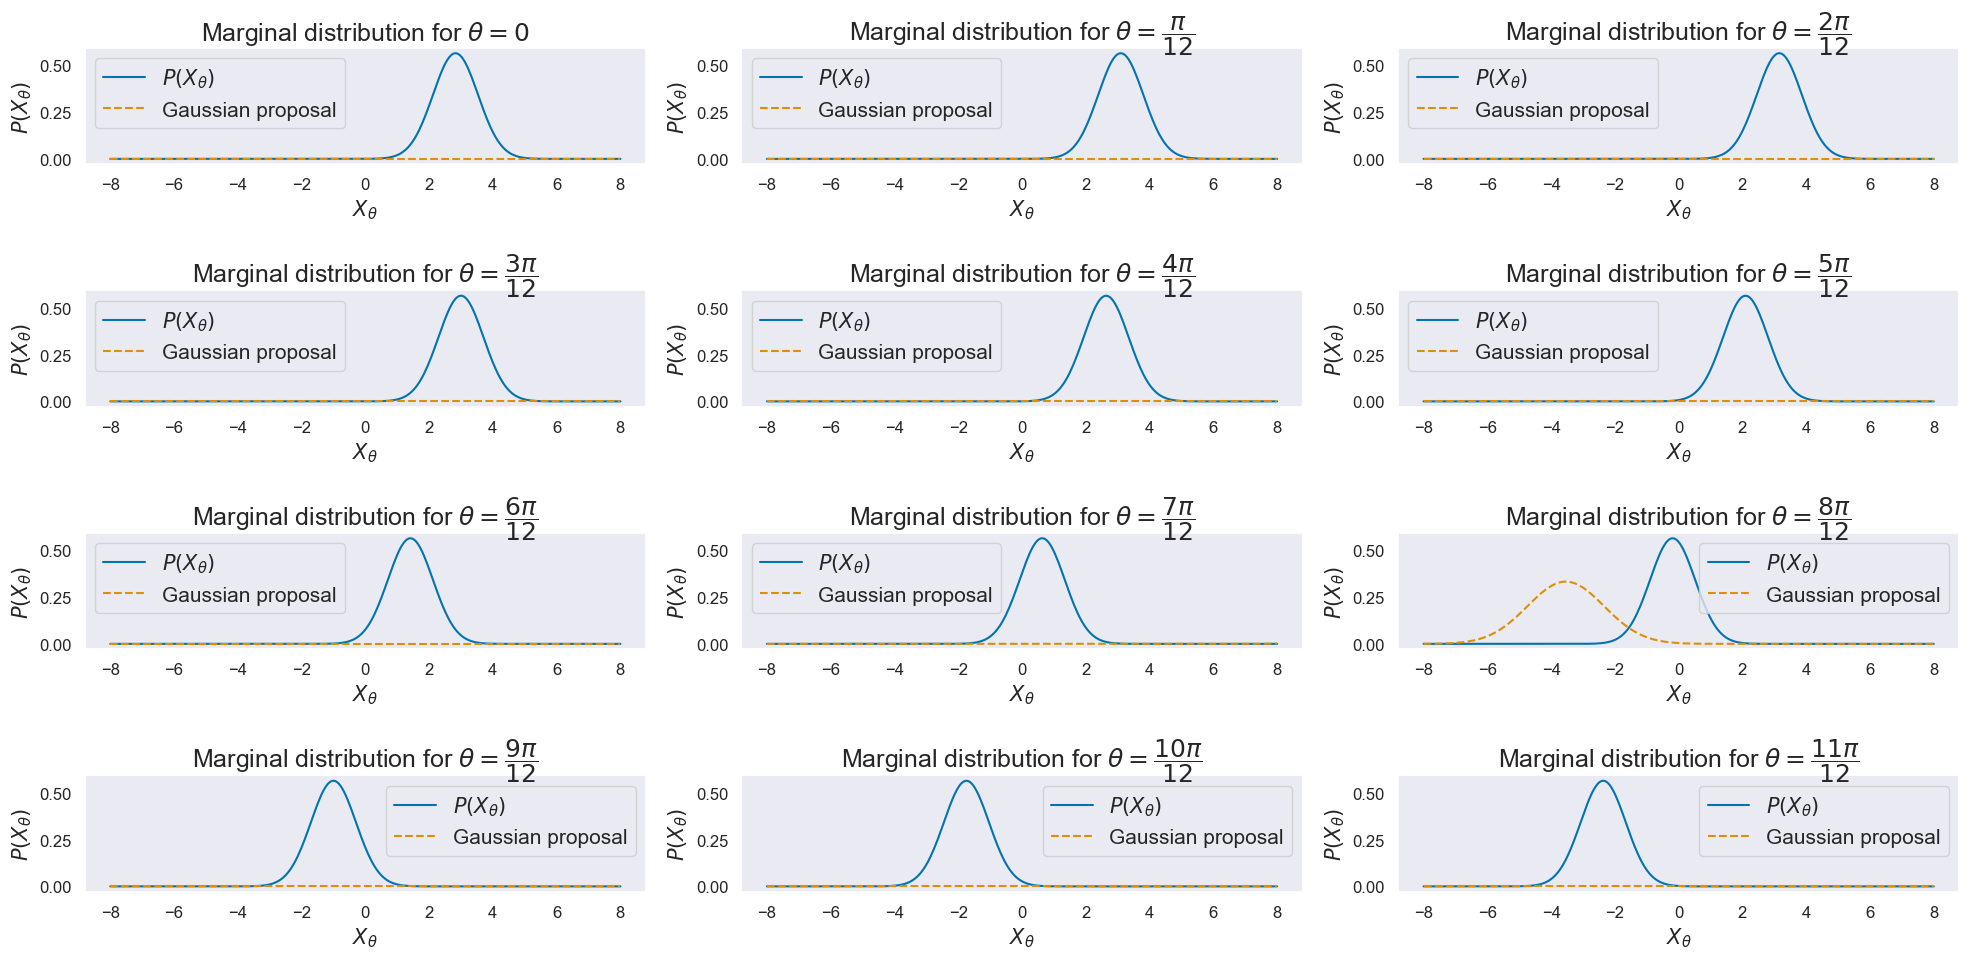

In [56]:
fig, axes = plt.subplots(n_theta // 3, 3, figsize=(20, 10))
labs = [r"$0$", rf"$\dfrac{{\pi}}{{{n_theta}}}$"] + [rf"$\dfrac{{{i}\pi}}{{{n_theta}}}$" for i in range(2, n_theta)]
axes = axes.flatten()
for i in tqdm(range(n_theta), desc="Plotting marginals"):
    ax = axes[i]
    ax.plot(marginals["X"], marginals[i], label=r"$P(X_{\theta})$")
    mu = marginals[i] @ marginals["X"] # <X> = sum_i p_i*x_i
    gaus = norm(loc=mu, scale=1.2).pdf(marginals["X"])
    ax.plot(marginals["X"], gaus, label="Gaussian proposal", linestyle="--")
    # ax.axvline(mu, color="k", linestyle="-", label="mean")
    ax.set_title(f"Marginal distribution for $\\theta=${labs[i]}")
    ax.set_xlabel(r"$X_{\theta}$")
    ax.set_ylabel(r"$P(X_{\theta})$")
    ax.legend()
    ax.grid()

fig.tight_layout()

## Sampling

In [ ]:
def rejection_sampling(target_pdf, proposal_pdf, proposal_sampler, n_samples, i, marginals):
    
    samples = []
    with tqdm(total=n_samples, desc=f"Rejection sampling for theta={i/np.pi:.3f}pi") as pbar:
        while (len(samples) < n_samples): # condition
            
            # xmin_index = np.argwhere(np.isclose(marginals[i], 0))[-1] # get the highest index for zero value
            # xmax_index = np.argwhere(np.isclose(marginals[i], 0))[0] # get the lowest index for zero value
            # x = proposal_sampler(xmin=marginals["X"][xmin_index], xmax=marginals["X"][xmax_index])  # Sample from proposal distribution
            x = proposal_sampler()  # Sample from proposal distribution
            if  marginals["X"].min() > x and x > marginals["X"].max():
                pbar.set_postfix({"rejected": x})
                pbar.update(0)
                continue  # Skip samples outside the range of marginals["X"]
            u = np.random.uniform(0, 1)
            
            q = proposal_pdf(x)
            
            p = target_pdf(x, i)
            if p is None:
                pbar.set_postfix({"rejected": x})
                pbar.update(0)
            elif u * q <= p:
                # print(f"appending {x:.3f}")
                samples.append(x)
                pbar.update(1)

    return samples


# Example usage:
def target_pdf(x, i=0):
    X = marginals["X"]
    index_mask = np.isclose(X, x, atol=5e-3)  # Adjusted tolerance
    index = np.argwhere(index_mask) # find index for bool

    assert len(index.shape) == 2, f"should always returns a nested list"
    if index.shape[0] > 0:
        index = index[index.shape[0] // 2]
        return marginals[i][index]

    elif index.shape[0] == 0:
        return None


proposal_sampler = lambda: np.random.normal(loc=0, scale=1) # Example proposal sampler

# proposal_sampler = lambda xmin, xmax: np.random.uniform(xmin, xmax) # Example proposal sampler

def get_samples(marginals, n_theta, n_samples=500, sampler="rejection"):
    xs = {}
    for i in trange(n_theta, desc="Sampling"):
    # for i in range(6):
        target = lambda x, i=i: target_pdf(x, i)
        proposal = norm(loc=marginals["X"] @ marginals[i], scale=1.2).pdf  # Proposal PDF
        if sampler == "rejection":
            raise NotImplementedError("Rejection sampling is not implemented yet.")
            xs[i] = rejection_sampling(target, proposal, proposal_sampler, n_samples=n_samples, i=i, marginals=marginals)
            
        elif sampler == "choice":
            dx = marginals["X"][1] - marginals["X"][0]
            prob = marginals[i] * dx

            # find index for negative values
            index_negative = np.argwhere(prob < 0)

            # raise error if all negative values not close to zero
            if not (np.isclose(prob[index_negative], 0)).all():
                raise ValueError(f"prob negatives : {prob[index_negative].ravel()}")

            # set negative values to zero
            prob = np.where(prob < 0, 0, prob)
            xs[i] = np.random.choice(marginals["X"], p=prob, replace=True, size=n_samples)
        else:
            raise ValueError(f"Unknown sampling type: {sampler}")

    return xs

samples = get_samples(marginals, n_theta=n_theta, n_samples=100_000, sampler="choice")

Sampling:   0%|          | 0/12 [00:00<?, ?it/s]

## Plot samples  

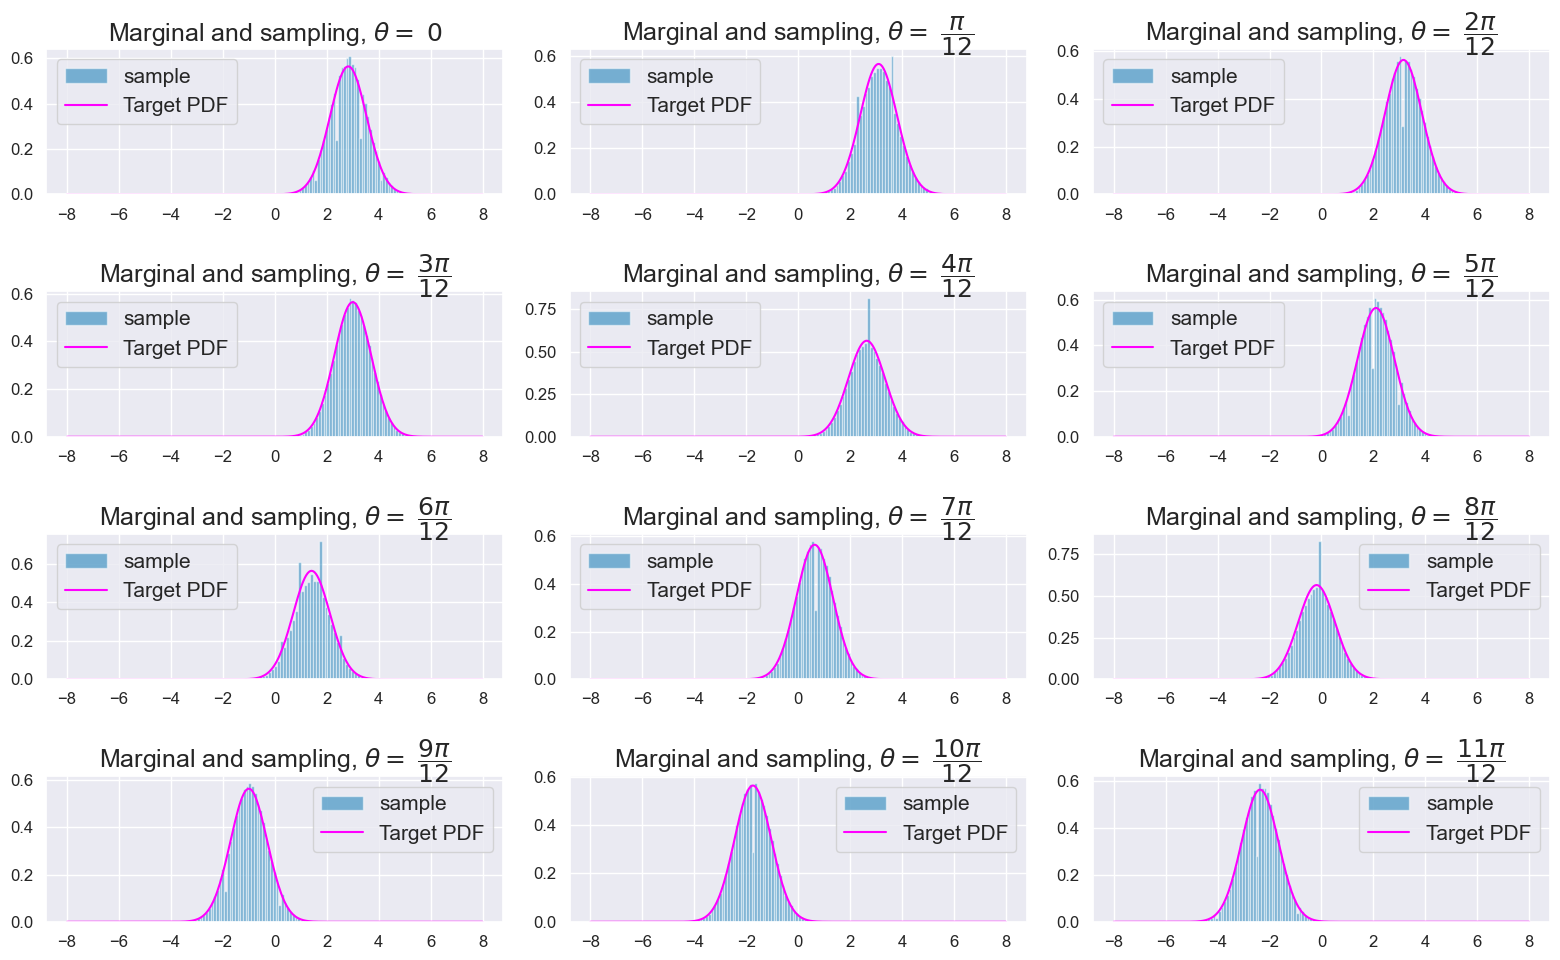

In [58]:
num_plots = n_theta // 3

fig, axes = plt.subplots(n_theta // 3, 3, figsize=(16, 10))
# axes = axes.flatten()
for i, ax in enumerate(axes.flatten()):
    ax.hist(samples[i], bins=60, density=True, label=f"sample", alpha=0.5)
    ax.plot(marginals["X"], marginals[i], label="Target PDF", color="magenta")
    # ax.plot(marginals["X"], norm.pdf(marginals["X"], loc=marginals["X"] @ marginals[i], scale=1.2), label="Proposal PDF", color="orange", linestyle="--")
    ax.set_title(f"Marginal and sampling, $\\theta =$ {labs[i]}")
    ax.legend()
    
fig.tight_layout()
    

Plotting angles: [  0.  75. 105. 135. 165.]


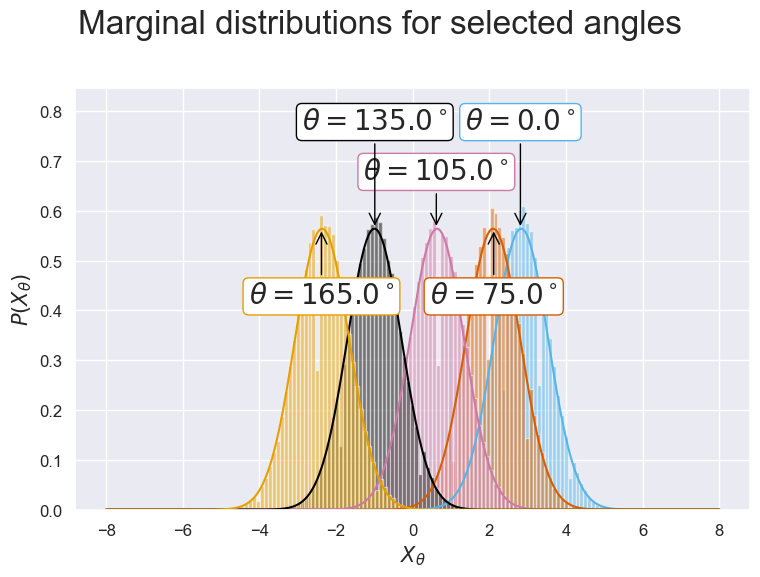

In [70]:
def plot_selected_angles(data, samples, idxs, **kwargs):
    angles = np.rad2deg([i*np.pi/len(samples) for i in idxs])
    print(f"Plotting angles: {angles}")
    
    
    default_colors = [
         "#56B4E9","#D55E00", 
        "#CC79A7", "#000000","#E69F00","#009E73",
    ]

    colors = kwargs.get("colors", default_colors)
    bins = kwargs.get("bins", 60)
    density = kwargs.get("density", True)
    alpha = kwargs.get("alpha", 0.5)
    figsize = kwargs.get("figsize", (16, 10))
    
    

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    X = data["X"]
    
    ax.set_xlabel(r"$X_{\theta}$")
    ax.set_ylabel(r"$P(X_{\theta})$")
    ax.set_ylim(bottom=0, top=1.5 * max(data[i].max() for i in idxs))
    
    for j, i in enumerate(idxs):
        
        col = colors[j % len(colors)] # cycle through colors if exhausted
        
        # plot histogram of samples and marginals
        ax.hist(samples[i], bins=bins, density=density, alpha=alpha, color=col)
        ax.plot(X, data[i], color=col)


        # annotate legend placement
        xmax = X[np.argmax(data[i])]
        ymax = data[i].max()

        xshift = 0
        yshift = 0.2 if j%3 == 0 else -0.15 if j%3 == 1 else 0.1 # will alternate height

        ann_arrow_point = (xmax, ymax)
        ann_text_place = (xmax + xshift, ymax + yshift)

        ax.annotate(
            fr"$\theta = {angles[j]:.1f}^\circ$",
            xy=ann_arrow_point,
            xytext=ann_text_place,
            arrowprops=dict(arrowstyle="->", color="black"),
            ha="center",
            bbox=dict(boxstyle="round, pad=0.2", edgecolor=col, facecolor="white")
        )
    
    fig.suptitle("Marginal distributions for selected angles")
    fig.tight_layout()
    return fig, ax


# fig, ax = plt.subplots(figsize=(16, 10))
fig, ax = plot_selected_angles(marginals, samples, idxs=[0, 5, 7, 9, 11], figsize=(8,6)); 
fig.savefig("plots/marginal_distributions.png")


In [60]:

default_colors = [
        "#E69F00", "#56B4E9",
        "#009E73", "#D55E00", 
        "#CC79A7", "#000000",
    ]

# colors = list(cycle(default_colors))  # Cycle through colors if more angles than colors
# col = colors[0 % len(default_colors)]

## Save measurement data

In [61]:
n_theta = len(samples)
T = np.array([np.pi/n_theta * i for i in range(n_theta)])
S = np.array([samples[i] for i in range(len(thetas))])
np.savez("measurements.npz", thetas=T, samples=S)
with open("measurements_metadata.txt", "w") as f:
    f.write(f"state_type,{state_type}\n")
    f.write(f"parity,{parity}\n")
    f.write(f"alpha,{alpha}\n")
    f.write(f"N_cutoff,{N_cutoff}\n")
    f.write(f"thetas [radians],{thetas}\n")


data = np.load("measurements.npz")
data["thetas"], data["samples"]


(array([0.        , 0.26179939, 0.52359878, 0.78539816, 1.04719755,
        1.30899694, 1.57079633, 1.83259571, 2.0943951 , 2.35619449,
        2.61799388, 2.87979327]),
 array([[ 3.23745819,  2.96989967,  4.36120401, ...,  2.75585284,
          3.34448161,  3.66555184],
        [ 3.82608696,  3.50501672,  4.09364548, ...,  2.64882943,
          3.71906355,  2.70234114],
        [ 2.16722408,  2.70234114,  3.50501672, ...,  3.61204013,
          3.13043478,  3.93311037],
        ...,
        [-0.4548495 , -0.02675585,  0.24080268, ..., -1.25752508,
          0.13377926, -1.63210702],
        [-2.80936455, -0.40133779, -1.63210702, ..., -2.3277592 ,
         -2.22073579, -1.04347826],
        [-2.48829431, -3.39799331, -1.52508361, ..., -3.50501672,
         -3.93311037, -2.27424749]], shape=(12, 100000)))